# Exercise 6-3

## LSTM

The following two cells will create a LSTM cell with one neuron.
We scale the output of the LSTM linear and add a bias.
Then the output will be wrapped by a sigmoid activation.
The goal is to predict a time series where every $n^{th}$ ($5^{th}$ in the current example) element is 1 and all others are 0.

a) Please read and understand the source code below.

b) Consult the output of the predictions. What do you observe? How does the LSTM manage to predict the next element in the sequence?

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [12]:
tf.reset_default_graph()
tf.set_random_seed(12314)

zero_steps = 5
learning_rate = 0.01
lstm_neurons = 1
out_dim = 1

num_features = 1
batch_size = zero_steps
window_size = zero_steps*2
time_steps = 5

x = tf.placeholder(tf.float32, [None, window_size, num_features], 'x')
y = tf.placeholder(tf.float32, [None, out_dim], 'y')

lstm = tf.nn.rnn_cell.LSTMCell(lstm_neurons)
state = lstm.zero_state(batch_size, dtype=tf.float32)

regression_w = tf.Variable(tf.random_normal([lstm_neurons]))
regression_b = tf.Variable(tf.random_normal([out_dim]))

outputs, state = tf.contrib.rnn.static_rnn(lstm, tf.unstack(x, window_size, 1), state)
output = outputs[-1]
predicted = tf.nn.sigmoid(output * regression_w + regression_b)
cost = tf.reduce_mean(tf.losses.mean_squared_error(y, predicted))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)


forget_gate = output.op.inputs[1].op.inputs[0].op.inputs[0].op.inputs[0]
input_gate = output.op.inputs[1].op.inputs[0].op.inputs[1].op.inputs[0]
cell_candidates = output.op.inputs[1].op.inputs[0].op.inputs[1].op.inputs[1]
output_gate_sig = output.op.inputs[0]
output_gate_tanh = output.op.inputs[1]


X = [
        [[ (shift-n) % zero_steps == 0 ] for n in range(window_size)
    ] for shift in range(batch_size)
]
Y = [[ shift % zero_steps == 0 ] for shift in range(batch_size) ]


with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    loss = 1
    epoch = 0
    while loss >= 1e-5:
        epoch += 1
        _, loss = sess.run([optimizer, cost], {x:X, y:Y})

        if epoch % (epochs//10) == 0:
            print("loss %.5f" % (loss), end='\t\t\r')
    print()
    
    outs, stat, pred, fg, inpg, cell_cands, outg_sig, outg_tanh = sess.run([outputs, state, predicted, forget_gate, input_gate, cell_candidates, output_gate_sig, output_gate_tanh], {x:X, y:Y})
    outs = np.asarray(outs)
    for batch in reversed(range(batch_size)):
        print("input:")
        print(np.asarray(X)[batch].astype(int).reshape(-1))
        print("forget\t\t%.4f\ninput gate\t%.4f\ncell cands\t%.4f\nout gate sig\t%.4f\nout gate tanh\t%.4f\nhidden state\t%.4f\ncell state\t%.4f\npred\t\t%.4f\n\n" % (fg[batch,0], inpg[batch,0], cell_cands[batch,0], outg_sig[batch,0], outg_tanh[batch,0], stat.h[batch,0], stat.c[batch,0], pred[batch,0]))

loss 0.00009		
input:
[0 0 0 0 1 0 0 0 0 1]
forget		0.0131
input gate	0.9996
cell cands	0.9994
out gate sig	1.0000
out gate tanh	0.7586
hidden state	0.7586
cell state	0.9929
pred		0.0000


input:
[0 0 0 1 0 0 0 0 1 0]
forget		0.8753
input gate	0.9849
cell cands	-0.0486
out gate sig	1.0000
out gate tanh	0.6757
hidden state	0.6757
cell state	0.8212
pred		0.0000


input:
[0 0 1 0 0 0 0 1 0 0]
forget		0.8510
input gate	0.9867
cell cands	-0.1324
out gate sig	0.9999
out gate tanh	0.5140
hidden state	0.5140
cell state	0.5682
pred		0.0000


input:
[0 1 0 0 0 0 1 0 0 0]
forget		0.7925
input gate	0.9896
cell cands	-0.2893
out gate sig	0.9999
out gate tanh	0.1625
hidden state	0.1625
cell state	0.1640
pred		0.0052


input:
[1 0 0 0 0 1 0 0 0 0]
forget		0.6143
input gate	0.9939
cell cands	-0.5755
out gate sig	0.9997
out gate tanh	-0.4391
hidden state	-0.4390
cell state	-0.4711
pred		0.9953




LSTM gates:
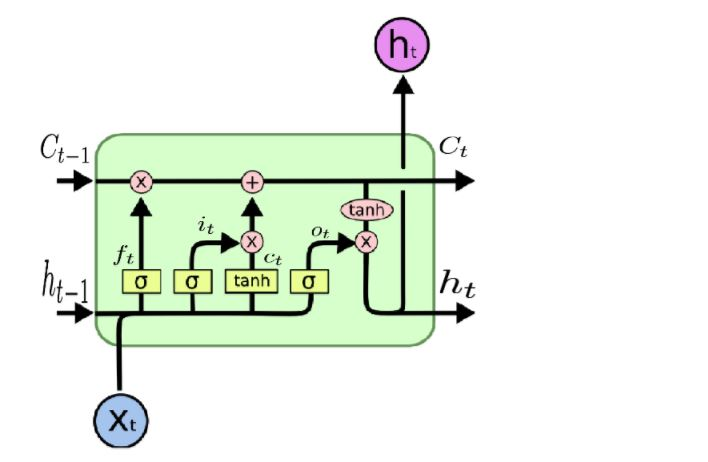

(image source: https://www.stratio.com/wp-content/uploads/2017/10/6-1.jpg)